In [264]:
import librosa
import numpy as np
from itertools import groupby
import pandas as pd
from sklearn.cluster import DBSCAN

In [298]:
# Wczytaj dźwięk
y, sr = librosa.load("sample_E01234567.wav", sr=None)

f0, voiced_flag, voiced_probs = librosa.pyin(
    y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('B7'), sr=sr
)

In [299]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
df = pd.DataFrame({
    'lp': range(len(f0)),
    'f0': f0,
    'voiced_flag': voiced_flag,
    'voiced_prob': voiced_probs
})
# dostosowanie cech
df['is_note'] = ((df['voiced_flag'] == True) & (df['voiced_prob'] >= 0.15)).astype(int) # dźwieki o określonym poziomie pstwa
df['voice_stability'] = df['is_note'].rolling(window=6, center=True).sum() # n nut w okienku kroczącym
df['voice_stability_median'] = df['f0'].rolling(window=11, center=True).median() # mediana okienka
df['voice_stability_stddev'] = df['f0'].rolling(window=11, center=True).std() # std dev okienka tj stabilność dźwięku
df['flag_to_take'] = ((df['is_note'] == 1) & (df['voice_stability'] >= 5)).astype(int) # warunek arbitralny test

df_wo_nan = df.dropna()

df_clean_voice = df_wo_nan.where(df_wo_nan["flag_to_take"] == 1).dropna()
df_dirty_voice = df_wo_nan.where(df_wo_nan["flag_to_take"] == 0).dropna()

X_clean = df_clean_voice["f0"]
y_clean = df_clean_voice["lp"]

X_dirty = df_dirty_voice["f0"]
y_dirty = df_dirty_voice["lp"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


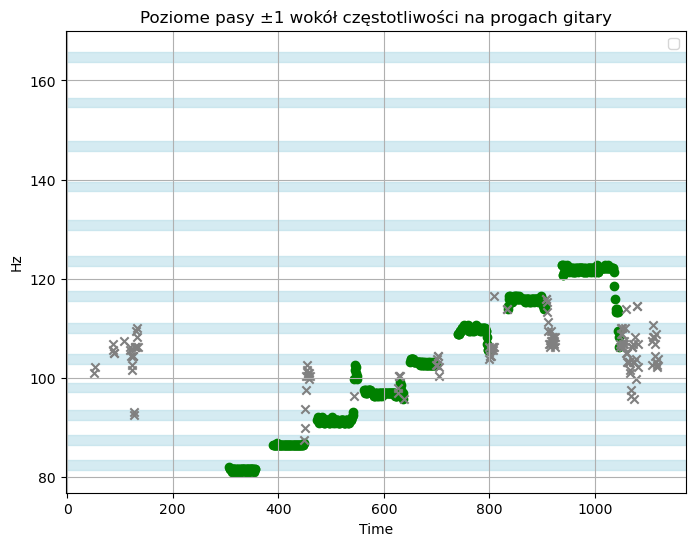

In [300]:
import matplotlib.pyplot as plt
import numpy as np

# Progi
y_values = [
    82.41, 87.31, 92.5, 98.0,
    103.83, 110.0, 116.54, 123.47,
    130.81, 138.59, 146.83, 155.56, 164.81
]

fig, ax = plt.subplots(figsize=(8, 6))

# Rysowanie poziomych pasów ±1 wokół każdej wartości
for y in y_values:
    ax.axhspan(y - 1, y + 1, color='lightblue', alpha=0.5)


plt.scatter(y_clean,X_clean, marker='o', c='green')
plt.scatter(y_dirty,X_dirty, marker='x', c='grey')

ax.set_xlabel('Time')
ax.set_ylabel('Hz')
ax.set_title('Poziome pasy ±1 wokół częstotliwości na progach gitary')
ax.legend()
plt.grid(True)
plt.show()

In [301]:
X_to_model = df_wo_nan[['f0', 'voiced_prob', 'is_note', 'voice_stability', 
           'voice_stability_median', 'voice_stability_stddev']]

#np.array
X_ = np.array(X_to_model)

In [302]:
clustering = DBSCAN(eps=1, min_samples=20).fit(X_)
#clustering.labels_

In [303]:
d = pd.DataFrame(X_)
d["lab"] = clustering.labels_
d["lab_outlier_real_group"] = d["lab"].apply(lambda x: 1 if x > -1 else 0) # wyznaczanie utlierów wg modelu
d["LP"] = d.index
d_ = d[["LP",0,"lab_outlier_real_group"]]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


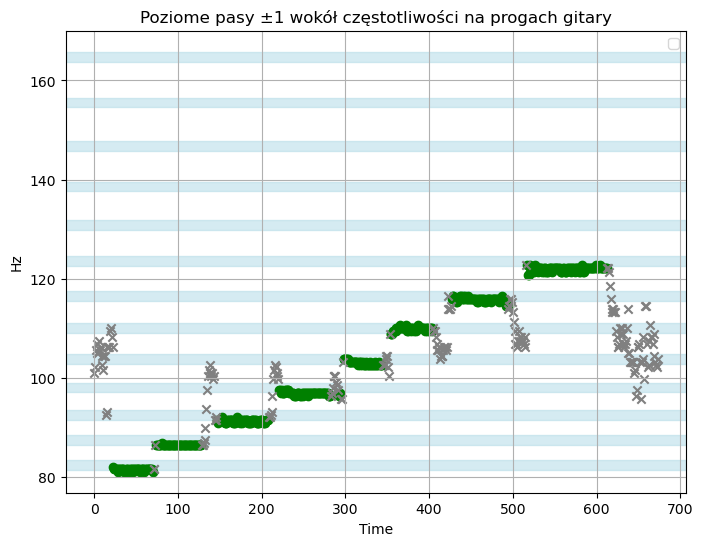

In [304]:
import matplotlib.pyplot as plt
import numpy as np

# Progi
y_values = [
    82.41, 87.31, 92.5, 98.0,
    103.83, 110.0, 116.54, 123.47,
    130.81, 138.59, 146.83, 155.56, 164.81
]

fig, ax = plt.subplots(figsize=(8, 6))

# Rysowanie poziomych pasów ±1 wokół każdej wartości
for y in y_values:
    ax.axhspan(y - 1, y + 1, color='lightblue', alpha=0.5)

df_clean_voice = d_.where(d_["lab_outlier_real_group"] == 1).dropna()
df_dirty_voice = d_.where(d_["lab_outlier_real_group"] == 0).dropna()

X_clean = df_clean_voice[0]
y_clean = df_clean_voice["LP"]

X_dirty = df_dirty_voice[0]
y_dirty = df_dirty_voice["LP"]

plt.scatter(y_clean,X_clean, marker='o', c='green')
plt.scatter(y_dirty,X_dirty, marker='x', c='grey')

ax.set_xlabel('Time')
ax.set_ylabel('Hz')
ax.set_title('Poziome pasy ±1 wokół częstotliwości na progach gitary')
ax.legend()
plt.grid(True)
plt.show()

In [305]:

x = df_clean_voice[0]
# Tabela progów dla struny E basowej
tab_freqs = {
    0: 82.41,
    1: 87.31,
    2: 92.50,
    3: 98.00,
    4: 103.83,
    5: 110.00,
    6: 116.54,
    7: 123.47,
    8: 130.81,
    9: 138.59,
    10: 146.83,
    11: 155.56,
    12: 164.81
}

def find_nearest_fret(freq):
    if freq is None:
        return None
    return min(tab_freqs, key=lambda x: abs(tab_freqs[x] - freq))

# Zamiana częstotliwości na numery progów
fret_positions = [find_nearest_fret(freq) for freq in x if freq is not None or freq != "nan"]

# Filtrowanie powtórzeń
tab = [k for k, _ in groupby(fret_positions)]

# Wyświetlenie tabulatury
print("E|", end="")
for fret in tab:
    if fret is not None:
        print(f"--{fret}--", end="")
    else:
        print("-----", end="")

E|--0----1----2----3----4----5----6----7--